# Yelp API - Lab


## Introduction 

Now that we've seen how the Yelp API works and some basic Folium visualizations, it's time to put those skills to work in order to create a working map! Taking things a step further, you'll also independently explore how to perform pagination in order to retrieve a full results set from the Yelp API!

## Objectives

You will be able to: 
* Create HTTP requests to get data from Yelp API
* Parse HTTP responses and perform data analysis on the data returned
* Perform pagination to retrieve troves of data!
* Create a simple geographical system on to view information about selected businesses, at a given location. 

## Problem Introduction

You've now worked with some API calls, but we have yet to see how to retrieve a more complete dataset in a programmatic manner. Returning to the Yelp API, the [documentation](https://www.yelp.com/developers/documentation/v3/business_search) also provides us details regarding the API limits. These often include details about the number of requests a user is allowed to make within a specified time limit and the maximum number of results to be returned. In this case, we are told that any request has a maximum of 50 results per request and defaults to 20. Furthermore, any search will be limited to a total of 1000 results. To retrieve all 1000 of these results, we would have to page through the results piece by piece, retrieving 50 at a time. Processes such as these are often referred to as pagination.

In this lab, you will define a search and then paginate over the results to retrieve all of the results. You'll then parse these responses as a DataFrame (for further exploration) and create a map using Folium to visualize the results geographically.

## Part I - Make the Initial Request

Start by making an initial request to the Yelp API. Your search must include at least 2 parameters: **term** and **location**. For example, you might search for pizza restaurants in NYC. The term and location is up to you, but make the request below.

In [1]:
#Your code here
import requests
import json
import pandas as pd
import folium
import matplotlib.pyplot as plt

def get_keys(path):
    with open(path) as f:
        return json.load(f)
    
keys = get_keys("/Users/alvar/.secret/yelp_api.json")
api_key = keys['api_key']

In [2]:
term='food'
location='Spartanburg SC'
url='https://api.yelp.com/v3/businesses/search'
limit=50

headers={'Authorization': 'Bearer {}'.format(api_key)}
url_params={'term': term.replace(' ', '+'),'location': location.replace(' ','+'),'limit':limit}

resp=requests.get(url, headers=headers, params=url_params)
resp.status_code==requests.codes.ok

True

In [3]:
print(type(resp.text))
print(resp.text[:1000])

<class 'str'>
{"businesses": [{"id": "u08NsW2Fy9K4DohR1UeVdg", "alias": "the-farmers-table-spartanburg", "name": "The Farmer's Table", "image_url": "https://s3-media2.fl.yelpcdn.com/bphoto/OpXoS4mlol_r7Gjs_CykkQ/o.jpg", "is_closed": false, "url": "https://www.yelp.com/biz/the-farmers-table-spartanburg?adjust_creative=GV_7iPHdUYLiLqCJG46o1w&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=GV_7iPHdUYLiLqCJG46o1w", "review_count": 300, "categories": [{"alias": "breakfast_brunch", "title": "Breakfast & Brunch"}, {"alias": "burgers", "title": "Burgers"}, {"alias": "salad", "title": "Salad"}], "rating": 4.0, "coordinates": {"latitude": 34.94733, "longitude": -81.93411}, "transactions": [], "price": "$$", "location": {"address1": "149 South Daniel Morgan Ave", "address2": null, "address3": "", "city": "Spartanburg", "zip_code": "29302", "country": "US", "state": "SC", "display_address": ["149 South Daniel Morgan Ave", "Spartanburg, SC 29302"]}, "phone": "+18645826554", "d

## Pagination

Now that you have an initial response, you can examine the contents of the json container. For example, you might start with ```response.json().keys()```. Here, you'll see a key for `'total'`, which tells you the full number of matching results given your query parameters. Write a loop (or ideally a function) which then makes successive API calls using the offset parameter to retrieve all of the results (or 5000 for a particularly large result set) for the original query. As you do this, be mindful of how you store the data. Your final goal will be to reformat the data concerning the businesses themselves into a pandas DataFrame from the json objects.

**Note: be mindful of the API rate limits. You can only make 5000 requests per day, and are also can make requests too fast. Start prototyping small before running a loop that could be faulty. You can also use time.sleep(n) to add delays. For more details see https://www.yelp.com/developers/documentation/v3/rate_limiting.**

In [4]:
resp.json().keys()

dict_keys(['businesses', 'total', 'region'])

In [5]:
# Your code here; use a function or loop to retrieve all the results from your original request
resp.json()['total']

603

In [6]:
resp.json()['businesses'][:2] #list of dictionaries

[{'id': 'u08NsW2Fy9K4DohR1UeVdg',
  'alias': 'the-farmers-table-spartanburg',
  'name': "The Farmer's Table",
  'image_url': 'https://s3-media2.fl.yelpcdn.com/bphoto/OpXoS4mlol_r7Gjs_CykkQ/o.jpg',
  'is_closed': False,
  'url': 'https://www.yelp.com/biz/the-farmers-table-spartanburg?adjust_creative=GV_7iPHdUYLiLqCJG46o1w&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=GV_7iPHdUYLiLqCJG46o1w',
  'review_count': 300,
  'categories': [{'alias': 'breakfast_brunch', 'title': 'Breakfast & Brunch'},
   {'alias': 'burgers', 'title': 'Burgers'},
   {'alias': 'salad', 'title': 'Salad'}],
  'rating': 4.0,
  'coordinates': {'latitude': 34.94733, 'longitude': -81.93411},
  'transactions': [],
  'price': '$$',
  'location': {'address1': '149 South Daniel Morgan Ave',
   'address2': None,
   'address3': '',
   'city': 'Spartanburg',
   'zip_code': '29302',
   'country': 'US',
   'state': 'SC',
   'display_address': ['149 South Daniel Morgan Ave',
    'Spartanburg, SC 29302']},
 

In [7]:
len(resp.json()['businesses'])

50

In [8]:
resp.json()['region']

{'center': {'longitude': -81.92848205566406, 'latitude': 34.9427560353289}}

In [9]:
import time 

def yelp_query(term,location,api_key,offset=0):
    url='https://api.yelp.com/v3/businesses/search'
    headers={'Authorization': 'Bearer {}'.format(api_key)}
    url_params={'term': term.replace(' ', '+'),'location': location.replace(' ','+'),'limit':50,'offset':offset}
    response=requests.get(url, headers=headers, params=url_params)
    return response

    
def get_all_results(term,location,api_key):
    response=yelp_query(term,location,api_key)
    total=response.json()['total']
    business_list=response.json()['businesses']
    current_results=len(business_list)
    while current_results < total:
        next_response=yelp_query(term,location,api_key,current_results)
        business_list=business_list+next_response.json()['businesses']
        current_results=len(business_list)
    return business_list

In [10]:
spt_restaurants=get_all_results('food','Spartanburg SC',api_key)

In [11]:
len(spt_restaurants)

603

In [12]:
df=pd.DataFrame(spt_restaurants)
df.head()

,alias,categories,coordinates,display_phone,distance,id,image_url,is_closed,location,name,phone,price,rating,review_count,transactions,url
0,the-farmers-table-spartanburg,"[{'alias': 'breakfast_brunch', 'title': 'Break...","{'latitude': 34.94733, 'longitude': -81.93411}",(864) 582-6554,713.416609,u08NsW2Fy9K4DohR1UeVdg,https://s3-media2.fl.yelpcdn.com/bphoto/OpXoS4...,False,"{'address1': '149 South Daniel Morgan Ave', 'a...",The Farmer's Table,+18645826554,$$,4.0,300,[],https://www.yelp.com/biz/the-farmers-table-spa...
1,snack-shack-spartanburg,"[{'alias': 'food_court', 'title': 'Food Court'...","{'latitude': 34.98714, 'longitude': -81.92256}",(864) 586-5551,4964.682102,34vmCMgxCwhJhwUgaGyYOg,https://s3-media3.fl.yelpcdn.com/bphoto/L4hBT3...,False,"{'address1': '1982 Chesnee Hwy', 'address2': '...",Snack Shack,+18645865551,NaN,4.5,16,[],https://www.yelp.com/biz/snack-shack-spartanbu...
2,cribbs-kitchen-spartanburg,"[{'alias': 'southern', 'title': 'Southern'}]","{'latitude': 34.94864, 'longitude': -81.93573}",(864) 699-9669,927.191113,s2qhEppd6QV8r2AjWmgjGQ,https://s3-media2.fl.yelpcdn.com/bphoto/hqbRlD...,False,"{'address1': '226 B W Main St', 'address2': ''...",Cribbs Kitchen,+18646999669,$$,4.0,301,[],https://www.yelp.com/biz/cribbs-kitchen-sparta...
3,monsoon-noodle-house-spartanburg,"[{'alias': 'noodles', 'title': 'Noodles'}, {'a...","{'latitude': 34.949137, 'longitude': -81.932463}",(864) 582-0618,796.925229,8w0sQG0JZyLNBFs9TGlC-A,https://s3-media2.fl.yelpcdn.com/bphoto/bhI_X8...,False,"{'address1': '129 W Main St', 'address2': '', ...",Monsoon Noodle House,+18645820618,$,4.0,155,[],https://www.yelp.com/biz/monsoon-noodle-house-...
4,the-8-6-pho-boiling-springs,"[{'alias': 'asianfusion', 'title': 'Asian Fusi...","{'latitude': 35.05273, 'longitude': -81.98873}",(864) 804-6208,13403.493559,pzwImWiHPa1nGvVso2U9dQ,https://s3-media4.fl.yelpcdn.com/bphoto/A5U5Es...,False,"{'address1': '4082 SC-9', 'address2': '', 'add...",The 8.6. Pho,+18648046208,NaN,4.0,10,"[pickup, delivery]",https://www.yelp.com/biz/the-8-6-pho-boiling-s...


## Finding a restaurant for dinner tonight  
### What categories are available?

In [13]:
def get_categories(series):
    categories=[]
    for i in range(len(series)):
        for j in range(len(series[i])):
            categories.append(series[i][j]['alias'])
    return categories
all_categories=get_categories(df['categories'])
all_categories.sort()
set(all_categories)

{'arcades',
 'asianfusion',
 'austrian',
 'bagels',
 'bakeries',
 'bars',
 'bbq',
 'beer_and_wine',
 'beerbar',
 'beergardens',
 'breakfast_brunch',
 'breweries',
 'brewpubs',
 'buffets',
 'burgers',
 'butcher',
 'cafes',
 'cajun',
 'cakeshop',
 'cambodian',
 'candy',
 'cantonese',
 'catering',
 'cheesesteaks',
 'chicken_wings',
 'chickenshop',
 'chinese',
 'chocolate',
 'cideries',
 'coffee',
 'coffeeroasteries',
 'colombian',
 'convenience',
 'cosmetics',
 'creperies',
 'cuban',
 'cupcakes',
 'customcakes',
 'custommerchandise',
 'delis',
 'deptstores',
 'desserts',
 'diners',
 'distilleries',
 'donuts',
 'drugstores',
 'farmersmarket',
 'florists',
 'food_court',
 'fooddeliveryservices',
 'foodstands',
 'foodtrucks',
 'french',
 'gardening',
 'giftshops',
 'gluten_free',
 'golf',
 'gourmet',
 'greek',
 'grocery',
 'hawaiian',
 'healthmarkets',
 'honduran',
 'hotdog',
 'hotdogs',
 'icecream',
 'importedfood',
 'indoor_playcenter',
 'irish',
 'italian',
 'japanese',
 'juicebars',
 'la

In [14]:
restaurants=[]
series=df['categories']
for i in range(len(series)):
    for j in range(len(series[i])):
        if series[i][j]['alias']=='steak':
            restaurants.append(df['name'][i])
        else:
            continue
restaurants

['Dudleys',
 'The Peddler Steak House',
 'Grille 221',
 "Basil's B52",
 'CityRange Steakhouse Grill',
 'Texas Roadhouse',
 "Phil's Steakhouse",
 "Demetre's Gourmet Grille & Bar",
 'LongHorn Steakhouse',
 "Carter's Steak and Seafood",
 'Los Mexicanos Restaurante',
 'Outback Steakhouse']

In [15]:
steak=['Dudleys',
 'The Peddler Steak House',
 'Grille 221',
 "Basil's B52",
 'CityRange Steakhouse Grill',
 'Texas Roadhouse',
 "Phil's Steakhouse",
 "Demetre's Gourmet Grille & Bar",
 'LongHorn Steakhouse',
 "Carter's Steak and Seafood",
 'Los Mexicanos Restaurante',
 'Outback Steakhouse']
steak_places=df.loc[df['name'].isin(steak)]
steak_places[['name','price','rating']]

,name,price,rating
35,Dudleys,$$,4.0
98,The Peddler Steak House,$$$,3.5
110,Grille 221,$,4.0
127,Basil's B52,$$,4.0
138,CityRange Steakhouse Grill,$$,3.5
172,Texas Roadhouse,$$,3.0
211,Phil's Steakhouse,NaN,4.5
229,Demetre's Gourmet Grille & Bar,$$,3.5
239,LongHorn Steakhouse,$$,3.0
255,Carter's Steak and Seafood,$$,3.0


## Exploratory Analysis

Take the restaurants from the previous question and do an initial exploratory analysis. At minimum, this should include looking at the distribution of features such as price, rating and number of reviews as well as the relations between these dimensions.

In [16]:
#Your code here
df.isna().sum()

alias              0
categories         0
coordinates        0
display_phone      0
distance           0
id                 0
image_url          0
is_closed          0
location           0
name               0
phone              0
price            169
rating             0
review_count       0
transactions       0
url                0
dtype: int64

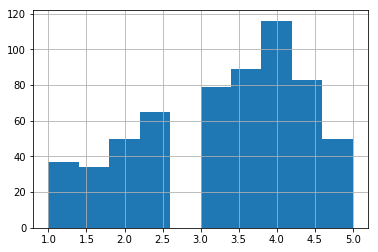

In [17]:
df.rating.hist();

C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


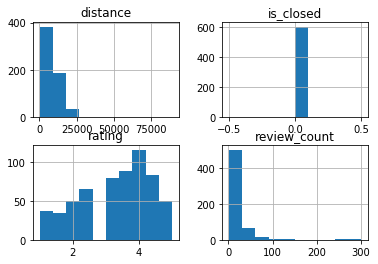

In [18]:
df.hist();

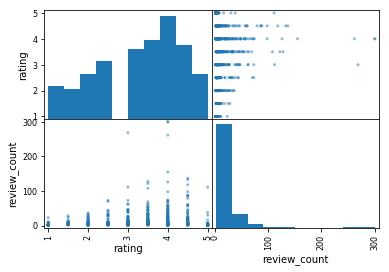

In [19]:
pd.plotting.scatter_matrix(df[['price','rating','review_count']]);

In [20]:
df.price.isna().sum()

169

In [21]:
df.dropna(subset=["price"],inplace=True)

In [22]:
df.loc[df["price"]=='$', "price_level"] = 1
df.loc[df["price"]=='$$', "price_level"] = 2
df.loc[df["price"]=='$$$', "price_level"] = 3
df.loc[df["price"]=='$$$$', "price_level"] = 4

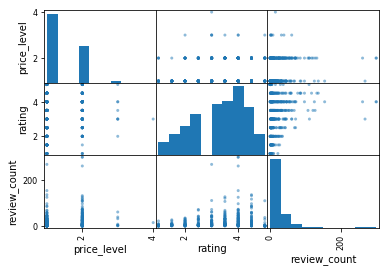

In [23]:
pd.plotting.scatter_matrix(df[['price_level','rating','review_count']]);

## Mapping

Look at the initial Yelp example and try and make a map using Folium of the restaurants you retrieved. Be sure to also add popups to the markers giving some basic information such as name, rating and price.

In [24]:
#Your code here
import folium

lat = 34.94
long = -81.93

base_map = folium.Map([lat, long], zoom_start=13)
base_map

In [25]:
steak_places.head()

,alias,categories,coordinates,display_phone,distance,id,image_url,is_closed,location,name,phone,price,rating,review_count,transactions,url
35,dudleys-spartanburg,"[{'alias': 'newamerican', 'title': 'American (...","{'latitude': 34.96595, 'longitude': -81.89096}",(864) 573-2626,4297.401415,qmPu3fby6luSaVXZC-zWFQ,https://s3-media1.fl.yelpcdn.com/bphoto/0b_uVy...,False,"{'address1': '1055 Fernwood Glendale Rd', 'add...",Dudleys,+18645732626,$$,4.0,55,[],https://www.yelp.com/biz/dudleys-spartanburg?a...
98,the-peddler-steak-house-spartanburg,"[{'alias': 'steak', 'title': 'Steakhouses'}, {...","{'latitude': 34.949044, 'longitude': -81.933125}",(864) 583-5874,817.282097,WVaJGwGHL1i4Xk6-a2fLZw,https://s3-media3.fl.yelpcdn.com/bphoto/pPZKCF...,False,"{'address1': '149 W Main St', 'address2': None...",The Peddler Steak House,+18645835874,$$$,3.5,33,[],https://www.yelp.com/biz/the-peddler-steak-hou...
110,grille-221-roebuck,"[{'alias': 'steak', 'title': 'Steakhouses'}, {...","{'latitude': 34.871111, 'longitude': -81.958189}",(864) 595-1178,8414.534186,r7T-_XpRLCoFncvuekuu8A,https://s3-media1.fl.yelpcdn.com/bphoto/8RfUId...,False,"{'address1': '4795 S Church Street Ext', 'addr...",Grille 221,+18645951178,$,4.0,4,[],https://www.yelp.com/biz/grille-221-roebuck?ad...
127,basils-b52-spartanburg,"[{'alias': 'steak', 'title': 'Steakhouses'}, {...","{'latitude': 34.96774, 'longitude': -81.92912}",(864) 583-5989,2758.464326,0og9VqApjjycm1YUBvWC0g,https://s3-media4.fl.yelpcdn.com/bphoto/_8904y...,False,"{'address1': '110 Garner Rd', 'address2': '', ...",Basil's B52,+18645835989,$$,4.0,7,[],https://www.yelp.com/biz/basils-b52-spartanbur...
138,cityrange-steakhouse-grill-spartanburg,"[{'alias': 'steak', 'title': 'Steakhouses'}, {...","{'latitude': 34.94244, 'longitude': -81.99741}",(864) 327-3333,6282.689255,OdGGmoiQAhZ3CZnJV1d5yQ,https://s3-media4.fl.yelpcdn.com/bphoto/2agaju...,False,"{'address1': '774 Spartan Bvld', 'address2': N...",CityRange Steakhouse Grill,+18643273333,$$,3.5,128,[],https://www.yelp.com/biz/cityrange-steakhouse-...


In [26]:
steak_places['name']

35                            Dudleys
98            The Peddler Steak House
110                        Grille 221
127                       Basil's B52
138        CityRange Steakhouse Grill
172                   Texas Roadhouse
211                 Phil's Steakhouse
229    Demetre's Gourmet Grille & Bar
239               LongHorn Steakhouse
255        Carter's Steak and Seafood
268         Los Mexicanos Restaurante
302                Outback Steakhouse
Name: name, dtype: object

In [28]:
#map of steak places
points=[]
indices=list(steak_places.index)
for entry in indices:
    name=steak_places['name'][entry]
    x=steak_places['coordinates'][entry]['latitude']
    y=steak_places['coordinates'][entry]['longitude']
    points.append((x,y,name))

for p in points:
    lat = p[0]
    long = p[1]
    name = p[2]
    popup_text = "Name: {}, Latitude: {}, Longitude: {}".format(name,lat,long)
    popup = folium.Popup(popup_text, parse_html=True)
    marker = folium.Marker(location=[lat, long],popup=popup)
    marker.add_to(base_map)
base_map

Name: Dudleys, Latitude: 34.96595, Longitude: -81.89096
Name: The Peddler Steak House, Latitude: 34.949044, Longitude: -81.933125
Name: Grille 221, Latitude: 34.871111, Longitude: -81.958189
Name: Basil's B52, Latitude: 34.96774, Longitude: -81.92912
Name: CityRange Steakhouse Grill, Latitude: 34.94244, Longitude: -81.99741
Name: Texas Roadhouse, Latitude: 34.9333838070533, Longitude: -81.9689238972818
Name: Phil's Steakhouse, Latitude: 34.89979, Longitude: -81.77172
Name: Demetre's Gourmet Grille & Bar, Latitude: 34.917141, Longitude: -82.1120987
Name: LongHorn Steakhouse, Latitude: 34.937697, Longitude: -81.988355
Name: Carter's Steak and Seafood, Latitude: 35.10773, Longitude: -82.03936
Name: Los Mexicanos Restaurante, Latitude: 34.97395, Longitude: -81.88041
Name: Outback Steakhouse, Latitude: 34.923452, Longitude: -81.98168


## Summary

Nice work! In this lab, you synthesized your skills for the day, making multiple API calls to Yelp in order to paginate through a results set, performing some basic exploratory analysis and then creating a nice map visual to display the results! Well done!